In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

# Read data and verified shape, type and head to ensure proper loading

In [2]:
# Read both sheets into separate DataFrames

file_path = "/Users/maggietang/Desktop/Included Health/Maggie's Client Analytics Analysis Exercise Data.xlsx"

background_df = pd.read_excel(
                            file_path,
                            sheet_name="background",
                            dtype={"teacher_id": str}
)
background_df.shape

(15472, 3)

In [3]:
background_df.dtypes

teacher_id         object
training_year       int64
board_cert_year     int64
dtype: object

In [4]:
background_df.head()

,teacher_id,training_year,board_cert_year
0,10000831640,1970,1970
1,10001811121,1970,1970
2,10002674776,1970,1970
3,10003837524,1970,1970
4,10004856810,1970,1970


In [5]:
# for performance sheet, since the Excel header is inconsistent (merged/misaligned), the cleanest and bulletproof way is to read 
# everything, then programmatically fix the headers and reshape it for analysis.

# Step 1. Read everything as plain text
performance_raw = pd.read_excel(file_path, sheet_name="performance_evaluations", header=None)

# Step 2. Fix headers
headers = performance_raw.iloc[1].tolist()
headers[0] = "teacher_id"
performance_clean = performance_raw.iloc[2:].copy()
performance_clean.columns = headers

# Step 3. Convert to long format
performance_df = performance_clean.melt(
    id_vars=["teacher_id"],
    var_name="year",
    value_name="score"
)

# Step 4. Clean and round
performance_df["year"] = performance_df["year"].astype(int)
performance_df["score"] = pd.to_numeric(performance_df["score"], errors="coerce").round(2)

performance_df.shape

(495104, 3)

In [6]:
performance_df.dtypes

teacher_id     object
year            int64
score         float64
dtype: object

In [7]:
performance_df.head()

,teacher_id,year,score
0,10000831640,1971,45.56
1,10001811121,1971,49.96
2,10002674776,1971,71.72
3,10003837524,1971,82.73
4,10004856810,1971,67.40


# Check missing values and summary statistics to verify data quality


In [8]:
background_df.isna().sum()

# No missing values across all columns

teacher_id         0
training_year      0
board_cert_year    0
dtype: int64

In [9]:
background_df.describe()

# Data aligns well within expected range

,training_year,board_cert_year
count,15472.000000,15472.000000
mean,1985.144648,1985.289749
std,9.160278,9.237954
min,1970.000000,1970.000000
25%,1977.000000,1977.000000
50%,1985.000000,1985.000000
75%,1993.000000,1994.000000
max,2001.000000,2001.000000


In [10]:
performance_df.isna().sum()

# No missing values across all columns

teacher_id         0
year               0
score         269389
dtype: int64

In [11]:
performance_df.describe()

# Data aligns well within expected range

,year,score
count,495104.000000,225715.000000
mean,1986.500000,69.484117
std,9.233102,23.402412
min,1971.000000,20.000000
25%,1978.750000,52.600000
50%,1986.500000,71.530000
75%,1994.250000,89.950000
max,2002.000000,100.000000


# Merge the two datasets

In [12]:
# Merged teacher background info with yearly performance scores.
merged_df = performance_df.merge(background_df, on="teacher_id", how="left")
merged_df = merged_df.drop_duplicates()
merged_df.shape

(495104, 5)

In [13]:
merged_df.head()

,teacher_id,year,score,training_year,board_cert_year
0,10000831640,1971,45.56,1970,1970
1,10001811121,1971,49.96,1970,1970
2,10002674776,1971,71.72,1970,1970
3,10003837524,1971,82.73,1970,1970
4,10004856810,1971,67.40,1970,1970


In [14]:
# rename col for clarity

merged_df = merged_df.rename(columns = {'year': 'score_year'})
merged_df.sample(5)

,teacher_id,score_year,score,training_year,board_cert_year
489311,19679600995,2002,74.68,1989,1989
263796,10772809573,1988,55.11,1971,1971
197661,22164405318,1983,NaN,1994,1994
183183,23250313346,1982,NaN,1996,1996
375491,14163775931,1995,56.88,1978,1978


# Define who “passed on first attempt”

In [15]:
# Created flag to identify teachers who passed certification on first attempt

merged_df["passed_first_attempt"] = (merged_df["board_cert_year"] == merged_df["training_year"])
merged_df.head()

,teacher_id,score_year,score,training_year,board_cert_year,passed_first_attempt
0,10000831640,1971,45.56,1970,1970,True
1,10001811121,1971,49.96,1970,1970,True
2,10002674776,1971,71.72,1970,1970,True
3,10003837524,1971,82.73,1970,1970,True
4,10004856810,1971,67.40,1970,1970,True


In [16]:
merged_df.passed_first_attempt.value_counts()

passed_first_attempt
True     429664
False     65440
Name: count, dtype: int64

# Filter for pre-1990 teachers (for Q1)

In [17]:
# Filtered pre-1990 teachers for baseline performance comparison.
pre1990_df = merged_df[merged_df["board_cert_year"] < 1990]
pre1990_df.shape

(318912, 6)

In [18]:
pre1990_df.head()

,teacher_id,score_year,score,training_year,board_cert_year,passed_first_attempt
0,10000831640,1971,45.56,1970,1970,True
1,10001811121,1971,49.96,1970,1970,True
2,10002674776,1971,71.72,1970,1970,True
3,10003837524,1971,82.73,1970,1970,True
4,10004856810,1971,67.40,1970,1970,True


In [19]:
# Calculated average performance by pass attempt flag

avg_perf_pre1990 = (pre1990_df.groupby("passed_first_attempt")["score"].mean().reset_index())
avg_perf_pre1990

,passed_first_attempt,score
0,False,60.584330
1,True,69.969255


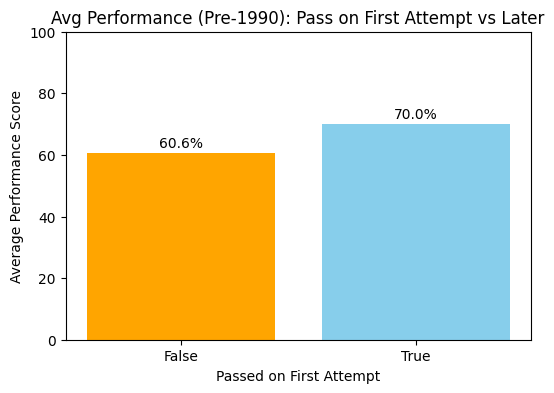

In [20]:
# Visualized pre-1990 average performance by pass attempt flag with labels

plt.figure(figsize=(6,4))
bars = plt.bar(
    avg_perf_pre1990["passed_first_attempt"].astype(str),
    avg_perf_pre1990["score"],
    color=["orange", "skyblue"]
)

plt.title("Avg Performance (Pre-1990): Pass on First Attempt vs Later")
plt.xlabel("Passed on First Attempt")
plt.ylabel("Average Performance Score")
plt.ylim(0, 100)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 1,
        f"{height:.1f}%",   # display as percentage
        ha="center", va="bottom", fontsize=10
    )

plt.show()

# Answer for Q1:

# Analyze post-1990 impact (for Q2)

In [21]:
# Calculated certification delay and post-1990 performance

merged_df2 = merged_df.copy()  # make a copy to work on Q2
merged_df2["certification_delay"] = (merged_df2["board_cert_year"] - merged_df2["training_year"])
merged_df2["period"] = merged_df2["board_cert_year"].apply(lambda x: "Pre-1990" if x < 1990 else "Post-1990")

merged_df2.sample(6)

,teacher_id,score_year,score,training_year,board_cert_year,passed_first_attempt,certification_delay,period
236604,14524577013,1986,65.27,1979,1979,True,0,Pre-1990
85535,18175824107,1976,NaN,1986,1988,False,2,Pre-1990
434126,10910865943,1999,NaN,1971,1971,True,0,Pre-1990
154888,10168800719,1981,78.55,1970,1970,True,0,Pre-1990
70230,18342881345,1975,NaN,1986,1986,True,0,Pre-1990
31824,10880579390,1973,64.11,1971,1972,False,1,Pre-1990


In [22]:
# Compute certification delay per teacher and average by period

delay_summary = (
    merged_df2[["teacher_id", "certification_delay", "period"]]
    .drop_duplicates(subset="teacher_id")                           
    .groupby("period")["certification_delay"]
    .mean()
    .reset_index()
)

# Round for readability
delay_summary["certification_delay"] = delay_summary["certification_delay"].round(2)

print(delay_summary)

      period  certification_delay
0  Post-1990                 0.30
1   Pre-1990                 0.06


In [23]:
merged_df2['certification_delay'].value_counts(normalize = True)

certification_delay
0    0.867826
1    0.121316
2    0.008919
3    0.001810
4    0.000129
Name: proportion, dtype: float64

In [24]:
merged_df2.period.value_counts()

period
Pre-1990     318912
Post-1990    176192
Name: count, dtype: int64

In [25]:
# Calculate each teacher's average performance score
teacher_perf = (
    merged_df2.groupby(["teacher_id", "period"])["score"]
    .mean()
    .reset_index()
)

# Then compute overall average by period
avg_score = teacher_perf.groupby("period")["score"].mean().reset_index()
print(avg_score)

      period      score
0  Post-1990  69.439984
1   Pre-1990  68.865098


# Answer for Q2: